In [2]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
from functools import partial
 
plt.rcParams.update({'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5}) 

In [3]:
print(tf.__version__)

2.2.0


In [4]:
import pae.create_datasets as crd

In [4]:
from pae.fid_score_tf2 import *

ModuleNotFoundError: No module named 'torch'

In [30]:
PROJECT_PATH = r"/storage/homefs/ch19g182/Python/PAE-master2"  
PARAMS_PATH = os.path.join(PROJECT_PATH,'params')

param_file = 'params_gan64_-1_64_infoGAN_AE_default3_full_sigma'#'params_gan2_-1_2_infoGAN_AE_default_full_sigma'#
flow       = 'hybrid4_nepoch159'#'hybrid4_nepoch99' 
params     = pickle.load(open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'rb'))

In [31]:
if params['data_set'] in ['celeba','gan2','gan64']: #
    train_input_fn, eval_input_fn = crd.build_input_fns(params,label=params['class_label'],flatten=False,num_repeat=15)
else:
    import pae.load_data as ld
    load_funcs=dict(mnist=ld.load_mnist, fmnist=ld.load_fmnist, cifar10=ld.load_cifar10, gan64=ld.load_gan64)
    load_func                                         = partial(load_funcs[params['data_set']])
    x_train, y_train, x_valid, y_valid, x_test, y_test = load_func(params['data_set'],flatten=False)

    if np.all(x_test)==None:
        x_test=x_valid

    def add_noise(x,sigma=0.1):
        nn = np.random.normal(size=np.shape(x))
        x  = x+nn*sigma
        return x

    x_train    = add_noise(x_train)/255.-0.5
    x_test     = add_noise(x_test)/255.-0.5
    x_valid    = add_noise(x_valid)/255.-0.5

loading gan64 dataset


In [32]:
generator_path   = os.path.join(params['module_dir'],'decoder')
encoder_path     = os.path.join(params['module_dir'],'encoder')
nvp_dir          = os.path.join(params['module_dir'],flow)

In [33]:
params['plot_dir']=r'plots' #os.path.join(params['plot_dir'],flow)
if not os.path.isdir(params['plot_dir']):
    os.makedirs(params['plot_dir'])

In [34]:
import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors

In [35]:
from pae.model_tf2 import get_prior
print('encoder_path',encoder_path)

encoder_path /storage/homefs/ch19g182/Python/PAE-master/modules/gan64/class-1/latent_size64/net_type_infoGAN/loss_AE/default3_full_sigma/encoder


In [75]:
tf.reset_default_graph()
if params['data_set'] in ['celeba','gan2','gan64']:
    x_val               = eval_input_fn()
    data              = train_input_fn()
else:
    data          = tf.placeholder(shape=[None]+params['data_shape'],dtype=tf.float32)

data_point    = tf.placeholder(shape=[None]+params['data_shape'],dtype=tf.float32)

latent_point  = tf.placeholder(shape=[None,params['latent_size']],dtype=tf.float32)
sample_size   = tf.placeholder_with_default(params['batch_size'], shape=[])
encoder       = hub.Module(encoder_path, trainable=False)
decoder       = hub.Module(generator_path, trainable=False)
nvp           = hub.Module(nvp_dir, trainable=False)
temp          = tf.placeholder_with_default(1.,shape=[])

prior         = get_prior(params['latent_size'])

encoded, _    = tf.split(encoder({'x':data},as_dict=True)['z'], 2, axis=-1)
decoded       = decoder({'z':encoded},as_dict=True)['x']
decoded_latent= decoder({'z':latent_point},as_dict=True)['x']

encoded_point, _    = tf.split(encoder({'x':data_point},as_dict=True)['z'], 2, axis=-1)
decoded_point       = decoder({'z':encoded_point},as_dict=True)['x']


sigma         = tf.reduce_mean(tf.sqrt(tf.square(data-decoded)),axis=0)

samples         = prior.sample(sample_size)

decoded_samples = decoder({'z':samples},as_dict=True)['x']
nvp_samples     = nvp({'z_sample':np.zeros((1,params['latent_size'])),'sample_size':1, 'u_sample':samples}, as_dict=True)['fwd_pass']
u_samples       = nvp({'z_sample':encoded,'sample_size':1, 'u_sample':samples}, as_dict=True)['bwd_pass']
decoded_nvp_samples = decoder({'z':nvp_samples},as_dict=True)['x']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [76]:
#print(x_val)
shape = params['data_shape']
print(shape)

[64, 64, 3]


In [77]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())

In [78]:
#print(sess.run(data).shape)
train_data = np.zeros([16,64,64,3])
train_data2 = np.zeros([16,64,64,3])
for k in range(16):
    train_data[k,:] = sess.run(data)
    train_data2[k,:] = sess.run(data)

In [45]:
try:
    latent_point1 = sess.run(encoded, feed_dict={data:data[0:params['batch_size']]})
    latent_point2 = sess.run(encoded, feed_dict={data:data[1:params['batch_size']+1]})
except:
    print('encoded',encoded[0])
    latent_point1 = sess.run(encoded)
    latent_point2 = sess.run(encoded)    
#latent_point1, latent_point2 = pickle.load(open('latent_points_for_interpolation_celeba.pkl','rb'))
interp = latent_point1+(latent_point2-latent_point1)*np.arange(5)[:, None,None]/5.

#pickle.dump([latent_point1,latent_point2],open('latent_points_for_interpolation_celeba.pkl','wb'))

encoded Tensor("strided_slice_3:0", shape=(64,), dtype=float32)


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument: transpose expects a vector of size 3. But input(1) is a vector of size 4
	 [[{{node module_apply_default/model/encoder/conv1/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
  (1) Invalid argument: transpose expects a vector of size 3. But input(1) is a vector of size 4
	 [[{{node module_apply_default/model/encoder/conv1/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
	 [[split/_447]]
0 successful operations.
0 derived errors ignored.

In [22]:
#plt.plot(interp[:,0,0])
#plt.plot(interp[:,0,1])
#print(params['shape'])
print(params['batch_size'])
print('interp',interp.shape)
decoded_grid = []
z = np.linspace(-2,2,7)
z1,z2 = np.meshgrid(z,z)
grid = np.stack((z1.flatten(),z2.flatten()),axis=1)
print('grid shape',grid.shape)
for kk in range(7):
    for jj in range(7):
        grid_z = []
        #print('grid[kk+jj,:]',grid[kk+jj,:].shape)
        for ii in range(16):
            grid_z += [grid[kk+jj,:]]#.reshape([1,2])]  #.reshape([1,2])
        grid_z = np.asarray(grid_z).reshape([16,2])  #.reshape((-1,2))
        print('shae',grid_z.shape)
        decoded_grid += sess.run(decoded_latent, feed_dict={latent_point:grid_z})
decoded_grid = np.asarray(decoded_grid)
print('shae',decoded_grid.shape)
np.save(os.path.join(params['plot_dir'],'grid_samples_gan2.npy'),decoded_grid)

16
interp (8, 16, 64)
grid shape (49, 2)
shae (16, 2)


ValueError: Cannot feed value of shape (16, 2) for Tensor 'Placeholder:0', which has shape '(None, 64)'

NameError: name 'sess' is not defined

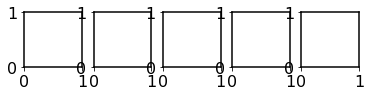

In [12]:
decoded_interp=[]

for jj in range(min(params['batch_size'],16)):
    fig, ax = plt.subplots(1,5,figsize=(6,1))
    imgs = []
    for ii in range(5):
        decoded_interp=sess.run(decoded_latent, feed_dict={latent_point:interp[ii]})[jj]
        img = np.squeeze(decoded_interp.reshape(shape))+0.5
        img_ = np.squeeze(decoded_interp.reshape(shape))+0.5
        #print(img_.shape)
        imgs += [img_]
        #print('decoded_interp',decoded_interp.shape)
        ax[ii].imshow(img, vmin=0,vmax=1, cmap='gray')
        ax[ii].axis('off')
        np.save(os.path.join(params['plot_dir'],'def2_pae_img_path%d.npy'%jj),imgs)
    #plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    #plt.savefig(os.path.join(params['plot_dir'],'interp%d.pdf'%jj),bbox_inches='tight')
    plt.show()

In [14]:
if params['data_set'] in ['celeba','gan2','gan64']:
    rec, d            = sess.run([decoded,data])
else:
    rec, d            = sess.run([decoded,data], feed_dict={data:x_valid[0:params['batch_size']]})
    
recs=[]
d=[]
delta = 1000%params['batch_size']
for ii in range(1000//params['batch_size']):
    if params['data_set'] in ['celeba','gan2','gan64']:
        recs+=[sess.run(decoded)]
        d+=[sess.run(data)]
    else:
        recs+=[sess.run(decoded, feed_dict={data:x_valid[ii*params['batch_size']:(ii+1)*params['batch_size']]})]

if params['data_set'] in ['celeba','gan2','gan64']:
    recs+=[sess.run(decoded)]
    d+=[sess.run(data)]
else:
    recs+=[sess.run(decoded, feed_dict={data:data_sample})]
    xval=x_valid
recs = np.asarray(recs).reshape([-1]+shape)[0:1000].reshape([1000,np.prod(shape)])
d = np.asarray(d).reshape([-1]+shape)[0:1000].reshape([1000,np.prod(shape)])
print(recs.shape)
print(d.shape)

(1000, 12288)
(1000, 12288)


In [15]:
full_sigma = np.sqrt(np.sum(np.square(255*d-255*recs),axis=1))
print('Mean Square error',np.mean(full_sigma))
print('with SD ',np.std(full_sigma))
np.save(os.path.join(params['plot_dir'],'def_MSE_gan64.npy'),full_sigma)

Mean Square error 7169.929
with SD  1476.2863


In [42]:
full_sigma = np.sqrt(np.mean(np.square(x_valid-recs),axis=0))
mean_sigma = np.mean(full_sigma)
mean_var   = np.mean(full_sigma**2)
plt.figure()
plt.title('pixel-wise sigma')
plt.imshow(np.squeeze((full_sigma).reshape(shape)), cmap='gray')
plt.colorbar()
plt.axis('off')
plt.savefig(os.path.join(params['plot_dir'],'measured_sigma.pdf'),bbox_inches='tight')
plt.show()
params['full_sigma']=full_sigma
pickle.dump(params,open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'wb'))
print('mean variance', mean_var)
print('minimum variance', np.min(full_sigma**2))
print('maximal variance', np.max(full_sigma**2))

ValueError: operands could not be broadcast together with shapes (626,64,64,3) (10000,64,64,3) 

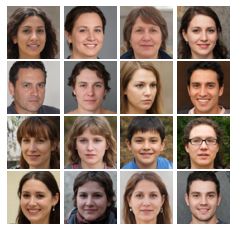

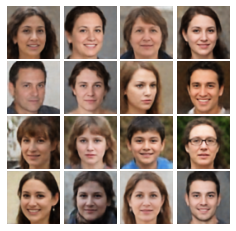

In [43]:

jj=1
plt.figure(figsize=(4,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(np.squeeze((d[ii]+0.5).reshape(shape)),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
plt.savefig(os.path.join(params['plot_dir'],'orig_valid_set.pdf'),bbox_inches='tight')
plt.show()

plt.figure(figsize=(4,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(np.squeeze((rec[ii]+0.5).reshape(shape)),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')

plt.savefig(os.path.join(params['plot_dir'],'rec_valid_set.pdf'),bbox_inches='tight')
plt.show()

In [39]:

random_nvp_samples=[]
for ii in range(16000//params['batch_size']+1):
    img = sess.run(decoded_nvp_samples, feed_dict={temp:1.0})
    random_nvp_samples+=[np.squeeze((img[0]+0.5).reshape(shape))]
#random_nvp_samples=np.asarray(random_nvp_samples).reshape((-1,np.prod(shape)))[0:5]

#print('random_nvp_samples',random_nvp_samples.shape)
np.save(os.path.join(params['plot_dir'],'def3_samples_gan64_pae.npy'),random_nvp_samples)

"""
plt.figure(figsize=(6,6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(25):
    plt.subplot(5,5,ii+1)
    plt.imshow(np.squeeze((random_nvp_samples[ii]+0.5).reshape(shape)),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
plt.savefig(os.path.join(params['plot_dir'],'nvp_samples.pdf'),bbox_inches='tight')
plt.show()

random_samples=[]
for ii in range(10000//params['batch_size']+1):
    random_samples+=[sess.run(decoded_samples)]
random_samples=np.asarray(random_samples).reshape((-1,np.prod(shape)))[0:10000]

plt.figure(figsize=(6,6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(25):
    plt.subplot(5,5,ii+1)
    plt.imshow(np.squeeze((random_samples[ii]+0.5).reshape(shape)),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
plt.savefig(os.path.join(params['plot_dir'],'raw_samples.pdf'),bbox_inches='tight')
plt.show()
"""

"\nplt.figure(figsize=(6,6))\nplt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)\nfor ii in range(25):\n    plt.subplot(5,5,ii+1)\n    plt.imshow(np.squeeze((random_nvp_samples[ii]+0.5).reshape(shape)),cmap='gray',vmin=0, vmax=1)\n    plt.axis('off')\nplt.savefig(os.path.join(params['plot_dir'],'nvp_samples.pdf'),bbox_inches='tight')\nplt.show()\n\nrandom_samples=[]\nfor ii in range(10000//params['batch_size']+1):\n    random_samples+=[sess.run(decoded_samples)]\nrandom_samples=np.asarray(random_samples).reshape((-1,np.prod(shape)))[0:10000]\n\nplt.figure(figsize=(6,6))\nplt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)\nfor ii in range(25):\n    plt.subplot(5,5,ii+1)\n    plt.imshow(np.squeeze((random_samples[ii]+0.5).reshape(shape)),cmap='gray',vmin=0, vmax=1)\n    plt.axis('off')\nplt.savefig(os.path.join(params['plot_dir'],'raw_samples.pdf'),bbox_inches='tight')\nplt.show()\n"

In [24]:
def evaluate_fid_score(fake_images, real_images,norm=True):
    np.random.shuffle(real_images)
    assert(len(real_images)>=10000)
    assert(len(real_images)>=10000)
    real_images = real_images[0:10000]
    fake_images = fake_images[0:10000]
    real_images = preprocess_fake_images(real_images, norm)
    fake_images = preprocess_fake_images(fake_images, norm)
    print(real_images.shape)
    inception_path = check_or_download_inception()

    create_inception_graph(inception_path)
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())

    print('calculating tf features...')
    real_out = get_activations_tf(real_images, sess)
    fake_out = get_activations_tf(fake_images, sess)
    fid_result = fid_score(real_out, fake_out)

    return fid_result

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
evaluate_fid_score(x_valid.reshape([-1]+shape), random_samples.reshape([-1]+shape))

In [ ]:
evaluate_fid_score(x_valid.reshape([-1]+shape), random_nvp_samples.reshape([-1]+shape))

In [ ]:
evaluate_fid_score(x_valid.reshape([-1]+shape), recs.reshape([-1]+shape))

In [57]:
print(train_data.shape)

AttributeError: 'list' object has no attribute 'shape'

In [81]:
#train_data2 = np.concatenate(train_data, axis=0 )
print('train_data2',train_data.dtype)
latent_point2 = sess.run(encoded_point,feed_dict={data_point:train_data})
latent_point1 = sess.run(encoded_point,feed_dict={data_point:train_data2})
interp = latent_point1+(latent_point2-latent_point1)*np.arange(5)[:, None,None]/5.

train_data2 float64


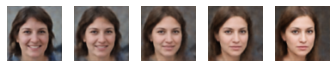

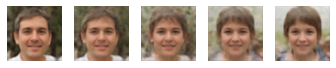

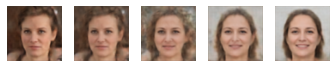

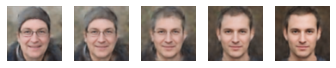

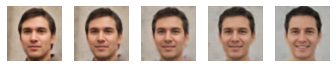

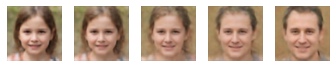

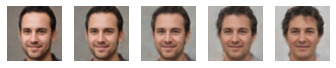

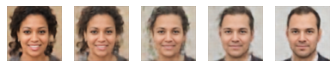

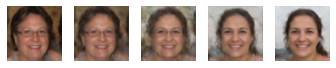

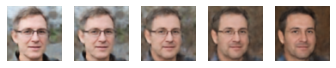

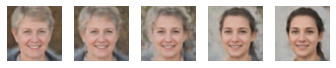

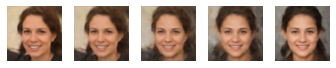

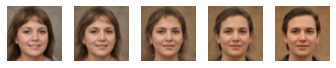

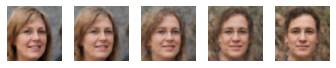

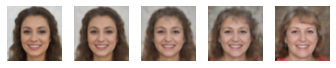

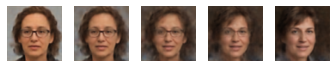

In [82]:
decoded_interp=[]

for jj in range(min(params['batch_size'],16)):
    fig, ax = plt.subplots(1,5,figsize=(6,1))
    imgs = []
    for ii in range(5):
        decoded_interp=sess.run(decoded_latent, feed_dict={latent_point:interp[ii]})[jj]
        img = np.squeeze(decoded_interp.reshape(shape))+0.5
        img_ = np.squeeze(decoded_interp.reshape(shape))+0.5
        #print(img_.shape)
        imgs += [img_]
        #print('decoded_interp',decoded_interp.shape)
        ax[ii].imshow(img, vmin=0,vmax=1, cmap='gray')
        ax[ii].axis('off')
        np.save(os.path.join(params['plot_dir'],'def2_pae_img_path%d.npy'%jj),imgs)
    #plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    #plt.savefig(os.path.join(params['plot_dir'],'interp%d.pdf'%jj),bbox_inches='tight')
    plt.show()